<a href="https://colab.research.google.com/github/FrancisDcruz/OpenFairness/blob/main/crime_fareness_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install aif360

     |████████████████████████████████| 174kB 8.5MB/s 


In [2]:
import pandas as pd 
from numpy import nan
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
#from sklego.linear_model import DemographicParityClassifier
#from sklego.metrics import p_percent_score
from sklearn.model_selection import cross_val_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [4]:
from google.colab import files
files.upload() 

Saving Daily_Inmates_In_Custody.csv to Daily_Inmates_In_Custody.csv


{'Daily_Inmates_In_Custody.csv': b'INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION\r\n20209345,2/15/2020,,MIN,Y,O,M,58,DE,N,N,117.62,N\r\n20149472,9/14/2020,,MIN,Y,B,M,30,DE,N,N,120.1,N\r\n133023,8/24/2018,,MAX,Y,B,M,42,DE,N,N,125.25,Y\r\n20029823,01/06/2019,,MAX,Y,B,M,36,DE,N,N,135.2,Y\r\n20211644,10/15/2020,,MED,N,W,M,52,DE,N,N,220.21,N\r\n122980,10/22/2020,,MED,N,B,M,37,DEP,N,N,,N\r\n20019267,3/14/2020,,MAX,Y,B,M,28,DE,N,Y,120.1,Y\r\n20009388,10/13/2020,,MAX,Y,B,M,32,DEP,N,N,160.1,N\r\n20057663,2/14/2018,,MED,N,B,M,51,DE,N,N,125.25,Y\r\n20036616,6/24/2019,,MAX,Y,B,M,39,DE,N,Y,230.34,Y\r\n20196814,7/19/2018,,MAX,N,B,M,21,DE,N,Y,125.25,Y\r\n20126766,12/06/2019,,MED,N,B,M,29,DE,N,N,130.96,Y\r\n20192843,9/27/2020,,MAX,N,W,M,36,DE,N,N,160.15,N\r\n20207687,1/25/2020,,MAX,Y,W,M,28,DE,N,Y,125.25,Y\r\n20211077,09/06/2020,,MIN,Y,O,M,28,DE,N,N,150.2,N\r\n20209165,02/01/2020,,MED,Y,A,M,25,DE,N,N,125.25,N\r\n20017335,08/0

Daily inmates in custody with attributes (custody level, mental health designation, race, gender, age, leagal status, sealed status, security risk group membership, top charge, and infraction flag)

The Bradh in the column mentions whether the inmates is under mental observation.
This model tries to predict if a particular inmate is under mental obervation or not

In [48]:
data=pd.read_csv('/content/Daily_Inmates_In_Custody.csv')

In [49]:
data.head()

,INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION
0,20209345,2/15/2020,NaN,MIN,Y,O,M,58.0,DE,N,N,117.62,N
1,20149472,9/14/2020,NaN,MIN,Y,B,M,30.0,DE,N,N,120.10,N
2,133023,8/24/2018,NaN,MAX,Y,B,M,42.0,DE,N,N,125.25,Y
3,20029823,01/06/2019,NaN,MAX,Y,B,M,36.0,DE,N,N,135.20,Y
4,20211644,10/15/2020,NaN,MED,N,W,M,52.0,DE,N,N,220.21,N


In [50]:
data.drop(data.columns[[0,1,2]],axis=1,inplace=True)
data.drop(columns=['SEALED'],axis=1,inplace=True)

In [51]:
data.head()

,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SRG_FLG,TOP_CHARGE,INFRTION
0,MIN,Y,O,M,58.0,DE,N,117.62,N
1,MIN,Y,B,M,30.0,DE,N,120.10,N
2,MAX,Y,B,M,42.0,DE,N,125.25,Y
3,MAX,Y,B,M,36.0,DE,N,135.20,Y
4,MED,N,W,M,52.0,DE,N,220.21,N


In [52]:
data.nunique()

CUSTODY_LEVEL         3
BRADH                 2
RACE                  6
GENDER                2
AGE                  61
INMATE_STATUS_DE      8
SRG_FLG               2
TOP_CHARGE          169
INFRTION              2
dtype: int64

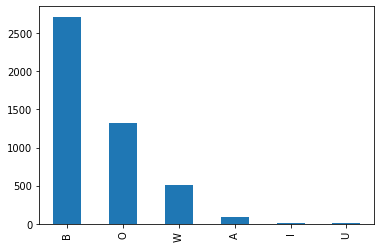

In [10]:
data['RACE'].value_counts().plot(kind='bar')

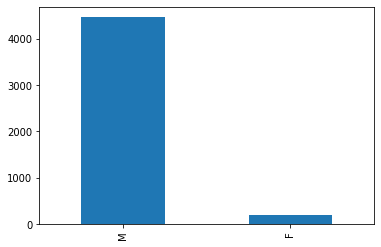

In [11]:
data['GENDER'].value_counts().plot(kind='bar')

On the Basic of the  above graphs we see that there Race and Gender are sensitive features which can cause bias in the prediction 

In [12]:
data['TOP_CHARGE'] = pd.to_numeric(data['TOP_CHARGE'], downcast="float")
data['TOP_CHARGE'].fillna(value=data['TOP_CHARGE'].mean(), inplace=True)

In [13]:
data=data.dropna()

In [14]:
data1=data
cols=['CUSTODY_LEVEL','RACE','GENDER','INFRTION','BRADH','SRG_FLG']
for i in cols:
  data1[i] = data1[i].astype('category')
  data1[i] = data1[i].cat.codes

In [15]:
cols=['CUSTODY_LEVEL','RACE','GENDER','INFRTION','BRADH','SRG_FLG']
for i in cols:
  data[i] = data[i].astype('category')
  data[i] = data[i].cat.codes

data=pd.get_dummies(data,columns=['INMATE_STATUS_DE'])

In [16]:
df1 = data.pop('BRADH') # remove column b and store it in df1
data['mental_status']=df1 # add b series as a 'new' column.

In [17]:
fair_data=data

In [18]:
'''data=pd.get_dummies(data, columns=['CUSTODY_LEVEL','GENDER','RACE','INMATE_STATUS_DE','SRG_FLG','INFRTION'])
data['mental_status'] = data['mental_status'].astype('category')
data['mental_status'] = data['mental_status'].cat.codes'''

"data=pd.get_dummies(data, columns=['CUSTODY_LEVEL','GENDER','RACE','INMATE_STATUS_DE','SRG_FLG','INFRTION'])\ndata['mental_status'] = data['mental_status'].astype('category')\ndata['mental_status'] = data['mental_status'].cat.codes"

In [19]:
data1.head()

,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SRG_FLG,TOP_CHARGE,INFRTION
0,2,1,3,1,58.0,DE,0,117.620003,0
1,2,1,1,1,30.0,DE,0,120.099998,0
2,0,1,1,1,42.0,DE,0,125.250000,1
3,0,1,1,1,36.0,DE,0,135.199997,1
4,1,0,5,1,52.0,DE,0,220.210007,0


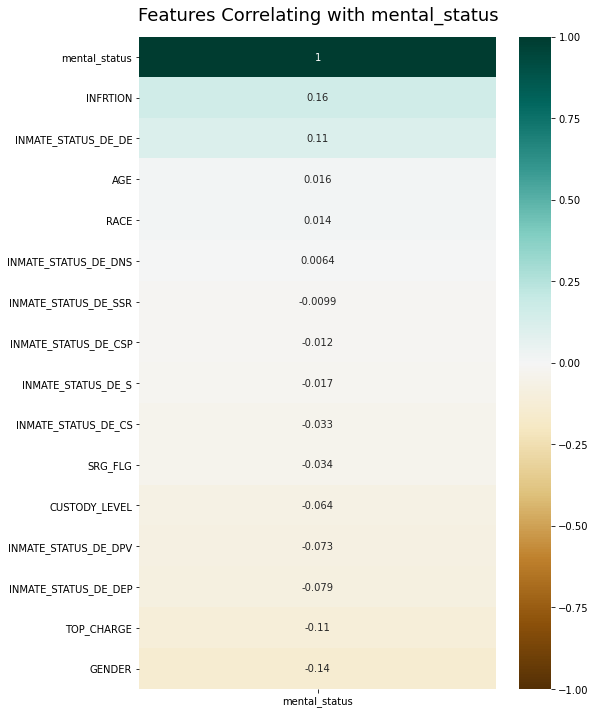

In [20]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['mental_status']].sort_values(by='mental_status', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with mental_status', fontdict={'fontsize':18}, pad=16);

In [21]:
data.head()

,CUSTODY_LEVEL,RACE,GENDER,AGE,SRG_FLG,TOP_CHARGE,INFRTION,INMATE_STATUS_DE_CS,INMATE_STATUS_DE_CSP,INMATE_STATUS_DE_DE,INMATE_STATUS_DE_DEP,INMATE_STATUS_DE_DNS,INMATE_STATUS_DE_DPV,INMATE_STATUS_DE_S,INMATE_STATUS_DE_SSR,mental_status
0,2,3,1,58.0,0,117.620003,0,0,0,1,0,0,0,0,0,1
1,2,1,1,30.0,0,120.099998,0,0,0,1,0,0,0,0,0,1
2,0,1,1,42.0,0,125.250000,1,0,0,1,0,0,0,0,0,1
3,0,1,1,36.0,0,135.199997,1,0,0,1,0,0,0,0,0,1
4,1,5,1,52.0,0,220.210007,0,0,0,1,0,0,0,0,0,0


In [22]:
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.30,random_state=0)

In [24]:
print(x_test.shape)
print(x_train.shape)

(1383, 15)
(3227, 15)


In [25]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

# **Predictions before performing fairness transformation**


Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2')
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)

In [27]:
#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.61 (+/- 0.03)


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[336 307]
 [232 508]]


0.6102675343456254

In [29]:
from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred)
precision

0.6233128834355828

In [30]:
from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred)
recall

0.6864864864864865

KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors = 19, metric = 'minkowski', p = 1,leaf_size=3)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)

In [32]:
#Cross Validation
scores = cross_val_score(classifier, x_test, y_test, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.60 (+/- 0.11)


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[329 314]
 [221 519]]


0.6131597975415762

SVC

In [34]:
from sklearn.svm import SVC
classifier= SVC(kernel='linear',C=10, random_state= 0)
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)

In [35]:
#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.59 (+/- 0.02)


In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[397 246]
 [314 426]]


0.5950831525668836

Naive Bayes


In [37]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.53 (+/- 0.01)


In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[643   0]
 [740   0]]


0.46493130874909616

Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
classifier = RandomForestClassifier(n_estimators = 500, max_depth=4,criterion = 'gini',max_features='auto', random_state = 0)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [41]:
#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.62 (+/- 0.02)


In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred= classifier.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[286 357]
 [167 573]]


0.6211135213304411

Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.53 (+/- 0.05)


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[357 286]
 [307 433]]


0.5712219812002892

# **Accuracy of models on original Data**

**Summary**

Logistic Regression:  
CV Accuracy: 0.60 (+/- 0.08),
Unseen Data prediction- 0.60





SVC:  
CV Accuracy: 0.58 (+/- 0.08),
Unseen Data prediction- 0.59

Random Forest:  
CV Accuracy: 0.55 (+/- 0.07),
Unseen Data prediction- 0.56

KNN:  
CV Accuracy: 0.55 (+/- 0.02),
Unseen Data prediction- 0.54

Naive Bayes:  
CV Accuracy: 0.53 (+/- 0.11), 
Unseen Data prediction- 0.50

Decision Tree:  
CV Accuracy: 0.52 (+/- 0.04),
Unseen Data prediction- 0.55

# Fairness Model Implementation 

In [45]:
fair_data.head()

,CUSTODY_LEVEL,RACE,GENDER,AGE,SRG_FLG,TOP_CHARGE,INFRTION,INMATE_STATUS_DE_CS,INMATE_STATUS_DE_CSP,INMATE_STATUS_DE_DE,INMATE_STATUS_DE_DEP,INMATE_STATUS_DE_DNS,INMATE_STATUS_DE_DPV,INMATE_STATUS_DE_S,INMATE_STATUS_DE_SSR,mental_status
0,2,3,1,58.0,0,117.620003,0,0,0,1,0,0,0,0,0,1
1,2,1,1,30.0,0,120.099998,0,0,0,1,0,0,0,0,0,1
2,0,1,1,42.0,0,125.250000,1,0,0,1,0,0,0,0,0,1
3,0,1,1,36.0,0,135.199997,1,0,0,1,0,0,0,0,0,1
4,1,5,1,52.0,0,220.210007,0,0,0,1,0,0,0,0,0,0


In [46]:
#fair_data.loc[(fair_data.RACE != 'B'),'RACE']='O'

GENDER: MALE=1,FEMALE=0          
MENTAL STATUS: YES=1,NO=0

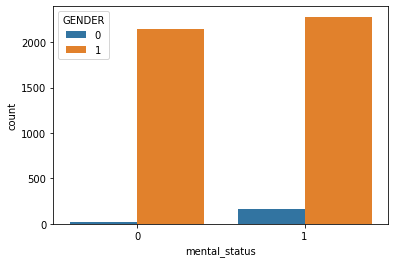

In [116]:
sns.countplot(data=fair_data,x='mental_status',hue='GENDER')

Since 0 is not in mental status so 0 is our favorable label and since male is 1 so 1 is our privileged group 

In [125]:
train_pp_bld = BinaryLabelDataset(df=fair_data,
                                  label_names=['mental_status'],
                                  protected_attribute_names=['GENDER'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'GENDER': 1}]
unprivileged_groups = [{'GENDER': 0}]

For this time we consider GENDER as the sensitive feature with 1 being the privileged group and 0 being the unprivileged group

In [126]:
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [127]:
explainer = MetricTextExplainer(metric_train_bld)
# Explain relevant metrics
explainer.mean_difference()
explainer.statistical_parity_difference()

'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.36552289828876794'